### Import Libraries and Start Date

In [1]:
import pandas as pd
import pandas_datareader.data as web
import quandl
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


In [9]:
start = datetime.datetime(2017,1,1)
end = datetime.date.today()

## up to date, however not as many featurs as quandl
#df = web.DataReader("TSLA", 'morningstar', start, end)
#df

### Plot Stock Price

In [8]:
s = "CSX"
csx = quandl.get("WIKI/" + s, start_date=start, end_date=end)
csx.head()

Open    High    Low  Close      Volume  Ex-Dividend  Split Ratio  \
Date                                                                            
2017-01-03  36.15  36.640  35.59  35.89   6535008.0          0.0          1.0   
2017-01-04  36.05  36.710  35.95  36.63   7255928.0          0.0          1.0   
2017-01-05  36.41  37.380  36.40  36.99  11583171.0          0.0          1.0   
2017-01-06  36.71  37.725  35.96  37.52  12350244.0          0.0          1.0   
2017-01-09  37.57  37.650  36.98  36.99   7406908.0          0.0          1.0   

            Adj. Open  Adj. High   Adj. Low  Adj. Close  Adj. Volume  
Date                                                                  
2017-01-03  35.739686  36.224124  35.186042   35.482637    6535008.0  
2017-01-04  35.640821  36.293330  35.541956   36.214238    7255928.0  
2017-01-05  35.996735  36.955725  35.986849   36.570152   11583171.0  
2017-01-06  36.293330  37.296809  35.551843   37.094136   12350244.0  
2017-01-09  37.143569  37.222661  36.560265   36.570152    7406908.0

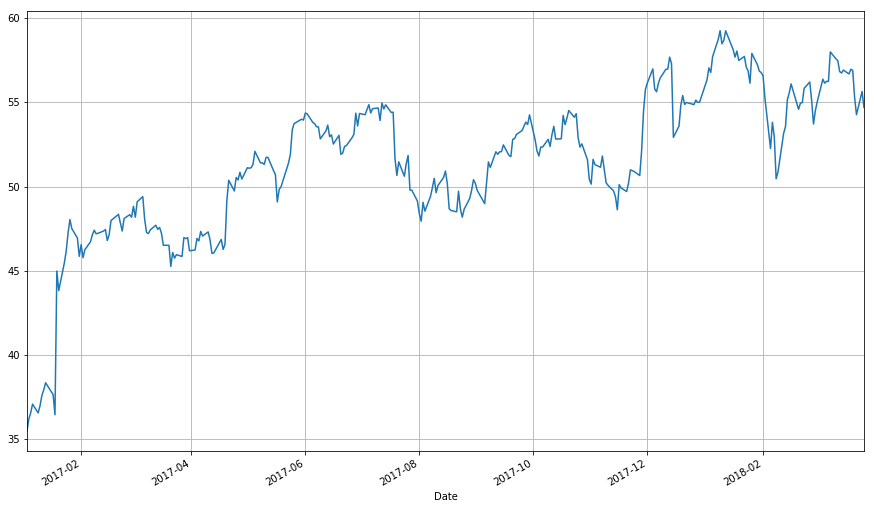

In [8]:
csx["Adj. Close"].plot(grid = True)

### Candlestick Plot

In [10]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import quotes_historical_yahoo_ohlc, candlestick_ohlc

In [11]:
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

In [15]:
pandas_candlestick_ohlc(csx, adj=True, stick="week")

### Industry Comparisons

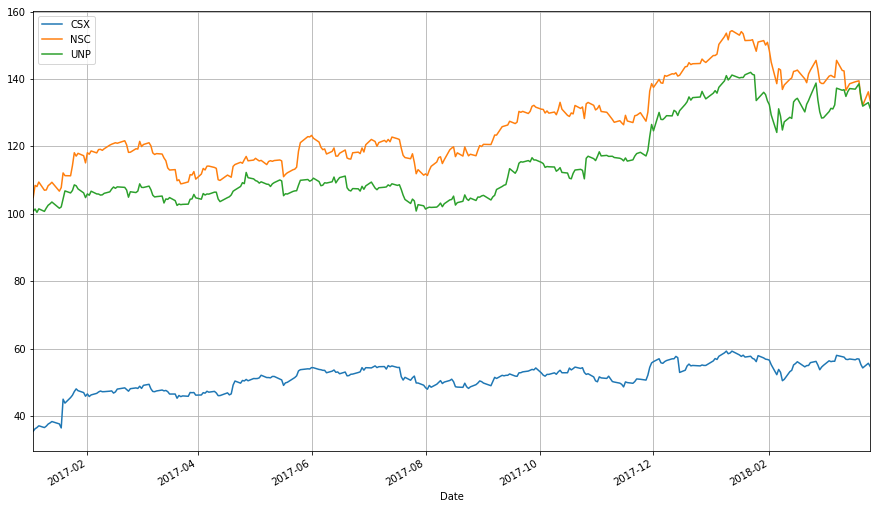

In [21]:
unp, nsc = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["UNP", "NSC"])

# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"CSX": csx["Adj. Close"],
                      "UNP": unp["Adj. Close"],
                      "NSC": nsc["Adj. Close"]})

stocks.plot(grid=True)

### Compared to Baseline (First Date)

In [22]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head() - 1

CSX       NSC       UNP
Date                                    
2017-01-03  0.000000  0.000000  0.000000
2017-01-04  0.020619  0.034115  0.006048
2017-01-05  0.030649  0.030844 -0.003804
2017-01-06  0.045417  0.043649  0.006535
2017-01-09  0.030649  0.020469 -0.000975

In [23]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

### Log Differences

In [25]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

CSX       NSC       UNP
Date                                    
2017-01-03       NaN       NaN       NaN
2017-01-04  0.020409  0.033546  0.006029
2017-01-05  0.009780 -0.003168 -0.009841
2017-01-06  0.014227  0.012345  0.010325
2017-01-09 -0.014227 -0.022461 -0.007490

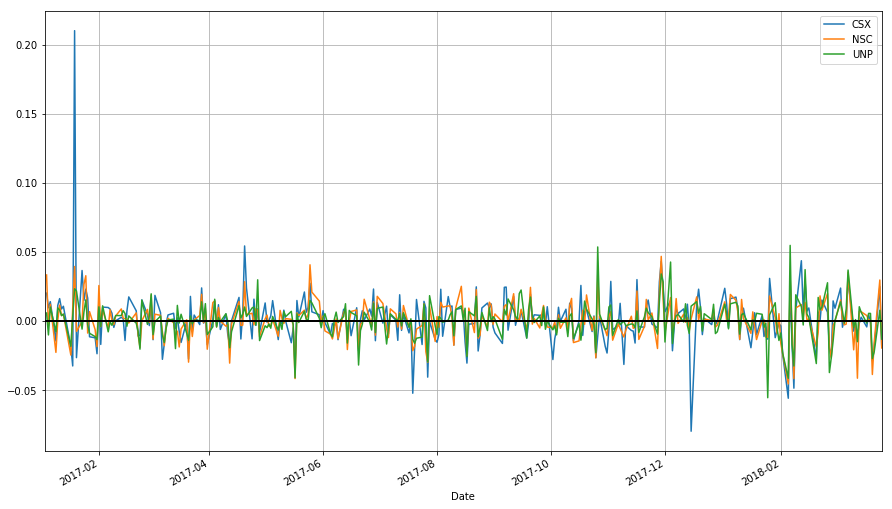

In [26]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

### Classsical Metrics
- Average return
- Volatility (the standard deviation of returns)
- $\alpha$ and $\beta$
- Sharpe ratio

In [27]:
stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

CSX         NSC         UNP
Date                                          
2018-03-21  -30.982703   27.121079  144.088982
2018-03-22 -723.322676 -968.925081 -680.200751
2018-03-23 -469.235901 -380.320317 -553.494759
2018-03-26  632.784339  753.135756  201.646732
2018-03-27 -433.902881 -485.744152 -324.181542

In [28]:
## Risk-free rate
tbill = quandl.get("FRED/TB3MS", start_date=start, end_date=end)
tbill.tail()

Value
Date             
2018-02-01   1.57
2018-03-01   1.70
2018-04-01   1.76
2018-05-01   1.86
2018-06-01   1.90

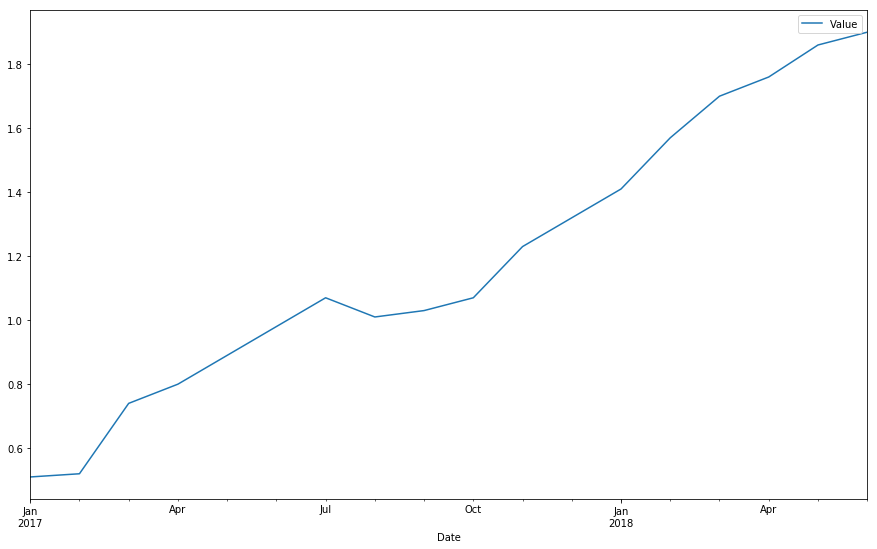

In [40]:
rrf = tbill.iloc[-1, 0]    # Get the most recent Treasury Bill rate
tbill.plot()

#### Stock Correlation

In [35]:
## How correlated are Industry Stocks
smcorr = stock_change_apr.drop("CSX", 1).corrwith(stock_change_apr.CSX) 
smcorr

NSC    0.646171
UNP    0.509580
dtype: float64

#### Rate of Return

In [51]:
sx = stock_change_apr.drop("CSX", 1).std()
sy = stock_change_apr.CSX.std()
sx

NSC    341.604501
UNP    326.445532
dtype: float64

In [52]:
sy

502.5854694918474

#### Volatility 

In [41]:
ybar = stock_change_apr.drop("CSX", 1).mean() - rrf
xbar = stock_change_apr.CSX.mean() - rrf
ybar

NSC    17.922335
UNP    19.718841
dtype: float64

In [42]:
xbar

33.512563912283447

#### $\alpha$ and $\beta$

In [53]:
beta = smcorr * sx / sy
alpha = ybar - beta * xbar
beta

NSC    0.439199
UNP    0.330989
dtype: float64

In [54]:
alpha

NSC    3.203666
UNP    8.626553
dtype: float64

#### Sharpe

We want the sharpe ratio to be large. A large Sharpe ratio indicates that the stock's excess returns are large relative to the stock's volatilitly

In [56]:
sharpe = (ybar - rrf)/sx
sharpe

NSC    0.046903
UNP    0.054584
dtype: float64

In [55]:
(xbar - rrf)/sy

0.062899876401612223

### Moving Averages

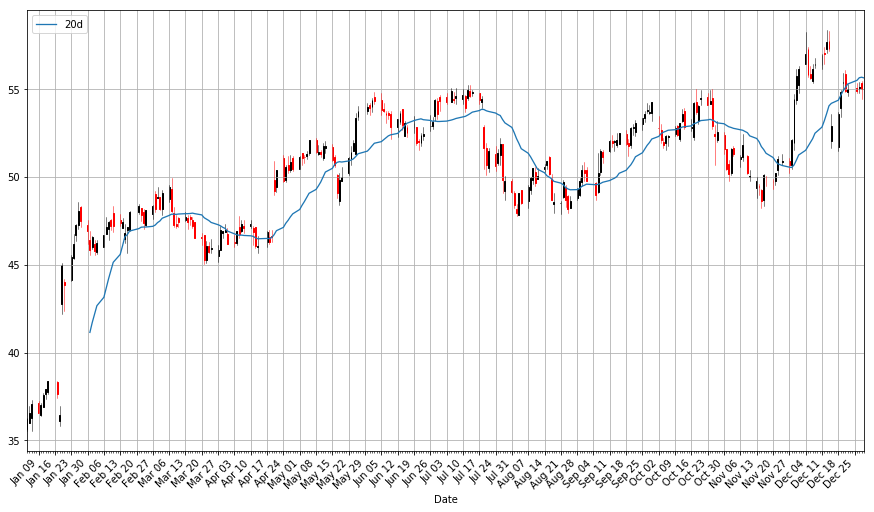

In [57]:
csx["20d"] = np.round(csx["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(csx.loc['2017-01-04':'2017-12-31',:], otherseries = "20d", adj=True)

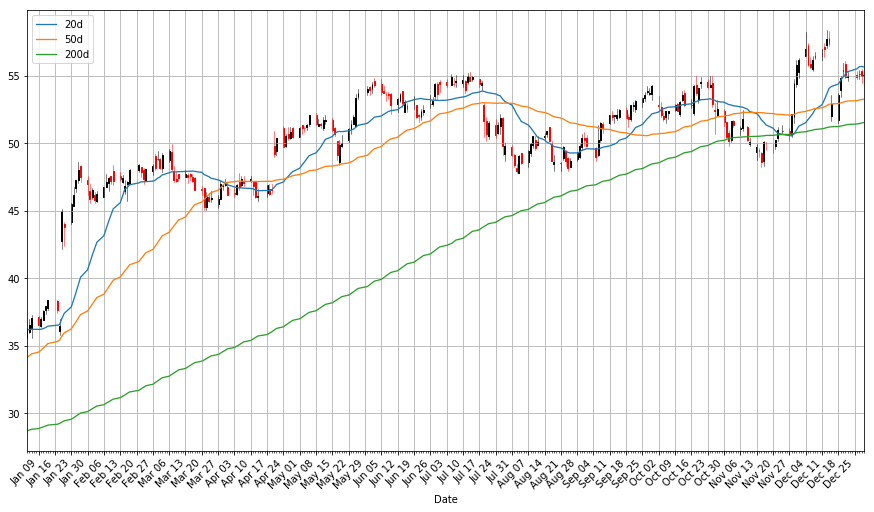

In [60]:
start = datetime.datetime(2010,1,1)
csx = quandl.get("WIKI/CSX", start_date=start, end_date=end)

## Add larger historical context
csx["20d"] = np.round(csx["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
csx["50d"] = np.round(csx["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
csx["200d"] = np.round(csx["Adj. Close"].rolling(window = 200, center = False).mean(), 2)


pandas_candlestick_ohlc(csx.loc['2017-01-04':'2017-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)

### Trading Strategy
if the fast moving average is above the slow moving average, this is a bullish regime (the bulls rule), and a bearish regime (the bears rule) holds when the fast moving average is below the slow moving average

#### Regime Change

In [63]:
csx['20d-50d'] = csx['20d'] - csx['50d']

## Discretize
csx["Regime"] = np.where(csx['20d-50d'] > 0, 1, 0)


# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
csx["Regime"] = np.where(csx['20d-50d'] < 0, -1, csx["Regime"])
csx.loc['2017-01-04':'2017-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)


In [64]:
csx["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [65]:
csx["Regime"].value_counts()

 1    1297
-1     715
 0      59
Name: Regime, dtype: int64

 When a bullish regime begins, a buy signal is triggered, and when it ends, a sell signal is triggered. Likewise, when a bearish regime begins, a sell signal is triggered, and when the regime ends, a buy signal is triggered (this is of interest only if you ever will short the stock, or use some derivative like a stock option to bet against the market).

#### Regime Change Signal

In [66]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = csx.loc[:, "Regime"].iloc[-1]
csx.loc[:, "Regime"].iloc[-1] = 0
csx["Signal"] = np.sign(csx["Regime"] - csx["Regime"].shift(1))
# Restore original regime data
csx.loc[:, "Regime"].iloc[-1] = regime_orig
csx.tail()

/Users/stronglab2/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Open   High    Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                          
2018-03-21  56.92  57.76  56.54  56.90  3749763.0          0.0          1.0   
2018-03-22  56.43  56.64  55.17  55.29  4307303.0          0.0          1.0   
2018-03-23  55.33  56.23  54.19  54.27  5145055.0          0.0          1.0   
2018-03-26  55.21  55.87  54.33  55.65  5498759.0          0.0          1.0   
2018-03-27  55.96  56.56  54.37  54.70  5246431.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume    20d  \
Date                                                                         
2018-03-21      56.92      57.76     56.54       56.90    3749763.0  56.23   
2018-03-22      56.43      56.64     55.17       55.29    4307303.0  56.24   
2018-03-23      55.33      56.23     54.19       54.27    5145055.0  56.17   
2018-03-26      55.21      55.87     54.33       55.65    5498759.0  56.14   
2018-03-27      55.96      56.56     54.37       54.70    5246431.0  56.12   

              50d   200d  20d-50d  Regime  Signal  
Date                                               
2018-03-21  56.07  53.42     0.16       1     0.0  
2018-03-22  55.99  53.43     0.25       1     0.0  
2018-03-23  55.91  53.43     0.26       1     0.0  
2018-03-26  55.85  53.44     0.29       1     0.0  
2018-03-27  55.76  53.45     0.36       1    -1.0

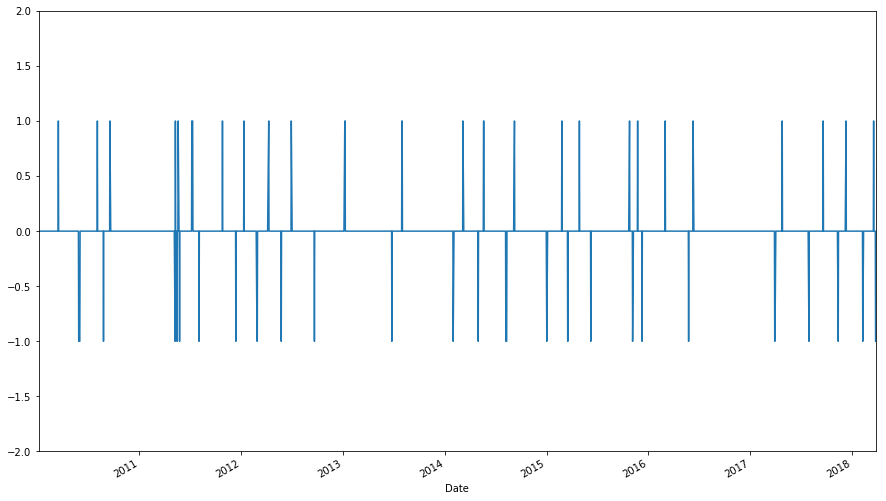

In [67]:
csx["Signal"].plot(ylim = (-2, 2))

In [68]:
csx["Signal"].value_counts()

 0.0    2011
-1.0      30
 1.0      29
Name: Signal, dtype: int64

#### Automatic Buy and Sell Prices
Letâ€™s now try to identify what the prices of the stock is at every buy and every sell.

In [73]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
csx_signals = pd.concat([
        pd.DataFrame({"Price": csx.loc[csx["Signal"] == 1, "Adj. Close"],
                     "Regime": csx.loc[csx["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": csx.loc[csx["Signal"] == -1, "Adj. Close"],
                     "Regime": csx.loc[csx["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
csx_signals.sort_index(inplace = True)
csx_signals.head()

Price  Regime Signal
Date                                
2010-03-16  14.606904       1    Buy
2010-05-28  14.878057       0   Sell
2010-06-01  14.673038      -1   Sell
2010-08-03  15.296635       1    Buy
2010-08-25  13.610930      -1   Sell

In [74]:
# Let's see the profitability of long trades
csx_long_profits = pd.DataFrame({
        "Price": csx_signals.loc[(csx_signals["Signal"] == "Buy") &
                                  csx_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(csx_signals["Price"] - csx_signals["Price"].shift(1)).loc[
            csx_signals.loc[(csx_signals["Signal"].shift(1) == "Buy") & (csx_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": csx_signals["Price"].loc[
            csx_signals.loc[(csx_signals["Signal"].shift(1) == "Buy") & (csx_signals["Regime"].shift(1) == 1)].index
        ].index
    })
csx_long_profits

End Date      Price     Profit
Date                                       
2010-03-16 2010-05-28  14.606904   0.271153
2010-08-03 2010-08-25  15.296635  -1.685705
2010-09-17 2011-05-09  15.707991   6.856608
2011-05-10 2011-05-16  22.818361  -1.358201
2011-05-20 2011-05-25  22.319488  -0.210507
2011-07-11 2011-08-03  22.562576  -2.033761
2011-10-26 2011-12-13  18.727949  -0.770311
2012-01-11 2012-02-27  20.638538  -1.336055
2012-04-09 2012-05-24  19.161073  -0.291658
2012-06-29 2012-09-20  19.891350  -0.655522
2013-01-08 2013-06-25  18.488565   2.627691
2013-08-01 2014-01-31  23.215105   1.627083
2014-03-07 2014-05-01  26.798500  -0.928247
2014-05-21 2014-08-08  27.531815   0.037685
2014-09-08 2015-01-02  29.260751   4.513816
2015-02-25 2015-03-18  33.322355  -0.141958
2015-04-29 2015-06-09  34.969072  -2.855134
2015-10-26 2015-11-06  26.703861  -0.785126
2015-11-24 2015-12-10  27.795378  -3.998193
2016-03-02 2016-05-25  23.827441   1.242327
2016-06-10 2017-03-30  26.173286  20.803162
2017-04-26 2017-07-31  50.399954  -1.257393
2017-09-20 2017-11-13  52.810000  -3.060000
2017-12-11 2018-02-09  56.970000  -6.090000
2018-03-20 2018-03-27  56.970000  -2.270000

### Simulated Portfolio
$\textbf{Rules}$
- Investing only 10% of the portfolio in any trade
- Exiting the position if losses exceed 20% of the value of the trade.
- Trades are done in batches of 100 stocks.

In [75]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": csx_long_profits.index,
                            "End": csx_long_profits["End Date"]})
csx_long_profits["Low"] = tradeperiods.apply(lambda x: min(csx.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
csx_long_profits.head()

End Date      Price    Profit        Low
Date                                                 
2010-03-16 2010-05-28  14.606904  0.271153  13.680156
2010-08-03 2010-08-25  15.296635 -1.685705  13.243606
2010-09-17 2011-05-09  15.707991  6.856608  15.436177
2011-05-10 2011-05-16  22.818361 -1.358201  21.454392
2011-05-20 2011-05-25  22.319488 -0.210507  21.630295

In [77]:
cash = 1000000
csx_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in csx_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    csx_backtest = csx_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)

csx_backtest.head()

End Date  End Port. Value  Profit per Share  Share Price  Shares  \
2010-03-16 2010-05-28     1.001844e+06          0.271153    14.606904  6800.0   
2010-08-03 2010-08-25     9.908868e+05         -1.685705    15.296635  6500.0   
2010-09-17 2011-05-09     1.034083e+06          6.856608    15.707991  6300.0   
2011-05-10 2011-05-16     1.027971e+06         -1.358201    22.818361  4500.0   
2011-05-20 2011-05-25     1.027003e+06         -0.210507    22.319488  4600.0   

            Start Port. Value  Stop-Loss Triggered  Total Profit  \
2010-03-16       1.000000e+06                  0.0   1843.837407   
2010-08-03       1.001844e+06                  0.0 -10957.083651   
2010-09-17       9.908868e+05                  0.0  43196.632450   
2011-05-10       1.034083e+06                  0.0  -6111.906402   
2011-05-20       1.027971e+06                  0.0   -968.331290   

              Trade Value  
2010-03-16   99326.947967  
2010-08-03   99428.130698  
2010-09-17   98960.341289  
2011-05-10  102682.622839  
2011-05-20  102669.646392

In [78]:
csx_backtest["End Port. Value"].plot()

#### Helper Functions to get more stocks

In [79]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average

    :return: pandas DataFrame containing stock orders

    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str

    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]

        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].loc[:, "Regime"].iloc[-1]
        s[1].loc[:, "Regime"].iloc[-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].loc[:, "Regime"].iloc[-1] = regime_orig

        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)

    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])

    return trades


def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes

    :return: pandas DataFrame with backtesting results

    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """

    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})

    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared

        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]

        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])

        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero

        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance

    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])

    return results

#### Include more stocks

In [89]:
(unp, nsc, ksu, gwr) = (quandl.get("WIKI/" + s, start_date=start,
                                            end_date=end) for s in ["UNP", "NSC", "KSU", "GWR"])
signals = ma_crossover_orders([("UNP", unp),
                              ("NSC",  nsc),
                              ("KSU",  ksu),
                              ("GWR",  gwr)],
                            fast = 20, slow = 50)

signals.head()

Price  Regime Signal
Date       Symbol                          
2010-03-16 GWR     34.350000     1.0    Buy
           KSU     33.931805     1.0    Buy
           NSC     45.449524     1.0    Buy
           UNP     31.379671     1.0    Buy
2010-05-21 UNP     29.798939    -1.0   Sell

In [91]:
bk = backtest(signals, 1000000)
bk.head()

End Cash  Portfolio Value  Profit per Share  \
Date       Symbol                                                     
2010-03-16 GWR     900385.000000   1000000.000000          0.000000   
           KSU     801982.765559   1000000.000000          0.000000   
           NSC     701993.811744   1000000.000000          0.000000   
           UNP     604716.832479   1000000.000000          0.000000   
2010-05-21 UNP     697093.541856    995099.730112         -1.580732   

                   Share Price  Shares      Start Cash  Total Profit  \
Date       Symbol                                                      
2010-03-16 GWR       34.350000  2900.0  1000000.000000           0.0   
           KSU       33.931805  2900.0   900385.000000           0.0   
           NSC       45.449524  2200.0   801982.765559           0.0   
           UNP       31.379671  3100.0   701993.811744           0.0   
2010-05-21 UNP       29.798939     0.0   604716.832479          -0.0   

                    Trade Value  Type  
Date       Symbol                      
2010-03-16 GWR     99615.000000   Buy  
           KSU     98402.234441   Buy  
           NSC     99988.953815   Buy  
           UNP     97276.979265   Buy  
2010-05-21 UNP     92376.709377  Sell

In [92]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

### Benchmarking

In [99]:
csx_value = csx.loc[start:end]
batches = 1000000 // np.ceil(100 * csx_value.loc[:,"Adj. Close"].iloc[0]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * csx_value.loc[:,"Adj. Close"].iloc[0] # How much money is used to buy SPY
final_val = batches * batch * csx_value.loc[:,"Adj. Close"].iloc[-1] + (1000000 - trade_val) # Final value of the portfolio
final_val

3966886.2111141728

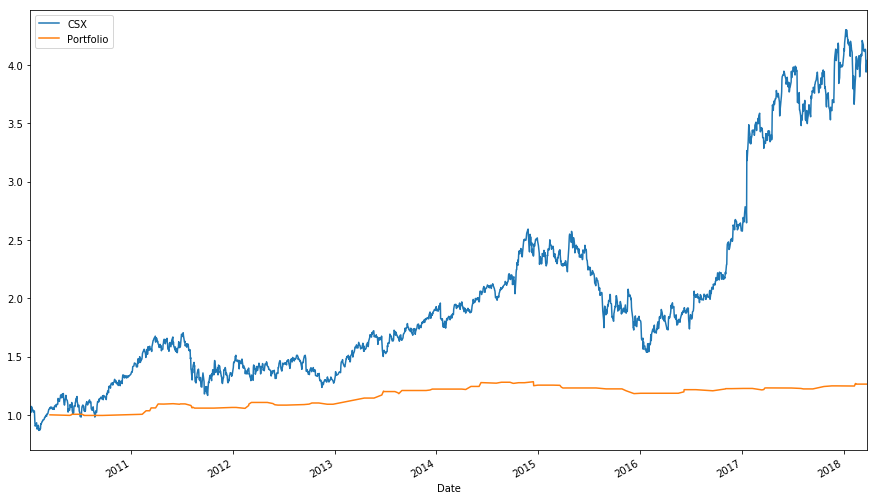

In [101]:
ax_bench = (csx_value["Adj. Close"] / csx_value.loc[:, "Adj. Close"].iloc[0]).plot(label = "CSX")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench